In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import numpy as np
import zipfile

def load_embeddings(embeddings_zip, embeddings_file):
  """Loads embeddings from a Numberbatch file inside a zip archive.

  Args:
      embeddings_zip: Path to the 'numberbatch-en.zip' file.
      embeddings_file: Name of the 'numberbatch-en.txt' file within the zip archive.

  Returns:
      A tuple of (embeddings, vocabulary)
          embeddings: A NumPy array of shape (num_concepts, embedding_dim)
          vocabulary: A list of concept labels in the order they appear in the embeddings array
  """

  with zipfile.ZipFile(embeddings_zip, 'r') as zip_ref:
    with zip_ref.open(embeddings_file) as f:
      header = f.readline().decode('utf-8').split()  # Read dimensions
      num_concepts, embedding_dim = int(header[0]), int(header[1])
      print("num_concepts: ", num_concepts, " embedding dim: ", embedding_dim)

      embeddings = np.zeros((num_concepts, embedding_dim))
      vocabulary = []

      for i, line in enumerate(f):
        parts = line.decode('utf-8').strip().split()  # Decode bytes
        vocabulary.append(parts[0])

        try:
          embeddings[i] = np.array(parts[1:], dtype=np.float32)
        except ValueError as e:
          print(f"Error on line {i+2}: {line}")
          print(f"Error message: {e}")

  return embeddings, vocabulary

# Load the embeddings and vocabulary
embeddings, vocabulary = load_embeddings("/content/drive/My Drive/WikiData/numberbatch-en.zip", "numberbatch-en.txt")
print(embeddings.shape)
print(len(vocabulary))


num_concepts:  516782  embedding dim:  300
(516782, 300)
516782


In [24]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModel

# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # Or another suitable BERT model
model1 = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import gzip
conceptnet_data = {}
with gzip.open("/content/drive/My Drive/WikiData/conceptnet-assertions-5.7.0.csv.gz", 'rt') as f:  # 'rt' for reading text
    for line in f:
        _, relation, start_concept, end_concept, extra_info = line.split('\t')
        extra_info_dict = json.loads(extra_info)  # Load JSON from extra_info

        if 'surfaceText' in extra_info_dict:
            surface_text = extra_info_dict['surfaceText']

            if start_concept not in conceptnet_data:
                 conceptnet_data[start_concept] = []
            if surface_text != None and surface_text!="null":
              conceptnet_data[start_concept].append(surface_text)  # Store the surface text
            # Include sense_label
            if 'sense_label' in extra_info_dict:
                sense_label = extra_info_dict['sense_label']
            else:
                sense_label = None  # Handle cases where it might be absent
            if 'label' in extra_info_dict:
                label = extra_info_dict['label']
            else:
                label = None
            if label != None and label!="null":
                conceptnet_data[start_concept].append(label)
            if sense_label != None and sense_label!="null":
                conceptnet_data[start_concept].append(sense_label)





In [ ]:
test = list(conceptnet_data.keys())[50:60]
print(len(list(conceptnet_data.keys())))

for t in test:
  print(t,": ",conceptnet_data[t])

In [ ]:
print(vocabulary.index("able"))

s= "/c/en/able"

print(s[6:])
print(s[6])
print(s[:6])

In [ ]:
embedding_lookup = {concept_label: idx for idx, concept_label in enumerate(vocabulary)}

In [ ]:
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
def get_concept_description(concept_label):
    if concept_label in conceptnet_data:
        return conceptnet_data[concept_label]
    else:
        print("No descriptions found for:", concept_label)
        return []

# Create an empty list to store the data for the dataframe
data = []


i=0
# Iterate directly through conceptnet_data
for concept_label, descriptions in conceptnet_data.items():
    if concept_label.split('/')[1]!='en':
      continue
    if descriptions:
        try:
            embedding = embeddings[embedding_lookup[concept_label.split('/')[2]]]
        except:
            print("ERROR: ",concept_label)
            embedding = None  # Handle cases where concept_label might not be in 'vocabulary'
            continue
        i=i+1
        if i%250==0:
          print(i,": ",concept_label)
        text_embeddings = []
        for description in descriptions:
            inputs = tokenizer(description, padding=True, truncation=True, return_tensors="pt")
            with torch.no_grad():
                outputs = model1(**inputs)
                token_embeddings = outputs.last_hidden_state[:,0,:]
            text_embeddings.append(token_embeddings)
        data.append({'text': text_embeddings, 'embedding': embedding})
# Create the pandas dataframe
df = pd.DataFrame(data)

# Display the dataframe
print(df)
print(len(df))

In [ ]:
# Save the dataframe as a CSV file
df.to_csv("concept_embeddings.csv")

In [ ]:
df = pd.DataFrame(data)
df.to_csv("concept_embeddings.csv")
print(len(df))

In [1]:
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
import zipfile
df = pd.read_csv('/content/drive/My Drive/WikiData/concept_embeddings (2).csv')
df2 = pd.read_csv('clusterData.csv')
df['cluster'] = df2['cluster']
del df2

In [2]:
import re

def convert_tensor_string(tensor_str):
    # Remove unnecessary characters
    clean_str = re.sub(r"\[|\]", "", tensor_str)

    # Split values into a list of strings
    str_values = clean_str.split()

    # Convert strings to floats and create a tensor
    float_values = [float(val) for val in str_values]
    tensor = torch.tensor(float_values)

    return tensor
df['embedding'] = df['embedding'].apply(convert_tensor_string)


In [3]:

import torch
import re


def extract_tensors(tensor_string):
    # Preprocessing: Remove extra characters if necessary
    clean_string = tensor_string.strip()

    # Split by a reliable delimiter
    tensor_substrings = clean_string.split("tensor(")[1:]

    tensors = []
    for substring in tensor_substrings:
        # Remove brackets and split into numbers
        clean_values = substring.strip("[])\n").split(",")
        clean_values = [val.strip() for val in clean_values]  # Remove leading/trailing spaces
        clean_values = [val.rstrip("])") for val in clean_values]  # Remove extra "])"
        float_values = []
        for val in clean_values:
          if val != "":
            float_values.append(float(val))
        # Convert to floats and create a tensor
        tensor = torch.tensor(float_values)
        tensors.append(tensor)

    # Create the final tensor of tensors
    tensor_of_tensors = torch.stack(tensors)
    return tensor_of_tensors

df['text'] = df['text'].apply(extract_tensors)

In [ ]:
import pickle
with open('processed_data.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
import pickle
import requests
import torch

import gzip
import json
import requests
import torch
import pandas as pd
import zipfile
with open('processed_data.pkl', 'rb') as f:
    df = pickle.load(f)

# Access your data (tensors are already in the correct format)
embeddings = df['embedding'].values
print(embeddings[0])  # Access an embedding tensor directly

In [ ]:
torch.cuda.empty_cache()
del model
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available: ", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

CUDA is available:  NVIDIA A100-SXM4-40GB


In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
device = torch.device("cuda")
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, latent_size)
        self.linear_mu = nn.Linear(latent_size, latent_size)
        self.linear_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, x):
        #print("encoder1: ",x.shape)
        out = torch.relu(self.linear1(x))
        #print("encoder2: ",out.shape)
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        #print("encoder3: ",out.shape)
        mu = self.linear_mu(out)
        logvar = self.linear_logvar(out)

        # Reparameterization trick for backpropagation through sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)  # Sample from the latent distribution
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size, decoder_hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, decoder_hidden_size)
        self.linear2 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.output_layer = nn.Linear(decoder_hidden_size, output_size)

    def forward(self, z):
        #print("decoder 1: ",z.shape)
        #print("decoder 1: ",z)
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
       # print("decoder 2: ",out)
        return out

class SentenceAttention(nn.Module):
    def __init__(self, attention_hidden_size):
        super().__init__()
        self.linear = nn.Linear(attention_hidden_size, attention_hidden_size).to(device)

    def forward(self, encoder_outputs):
      # Transform x using a linear layer; output shape will be (sq, b, hidden_size)
      x_transformed = self.linear(encoder_outputs)
      # Step 2: Compute attention scores using softmax across the sequence dimension (sq)
      # Attention scores shape: (sq, b, hidden_size) -> (b, sq, hidden_size) for softmax
      x_transposed = x_transformed.transpose(0, 1)  # Transposing for softmax operation
      attention_scores = F.softmax(x_transposed, dim=1)  # Applying softmax; shape remains (b, sq, hidden_size)

      # Step 3: Apply attention scores to the original input tensor
      # For weighted sum, first transpose x back: (sq, b, hidden_size) -> (b, sq, hidden_size)
      x = encoder_outputs.transpose(0, 1)  # Transposing x to match attention_scores shape
      # Compute the context vector as the weighted sum of the input vectors
      # (b, sq, hidden_size) * (b, sq, hidden_size) -> (b, hidden_size) after summing over sq dimension
      context_vector = torch.sum(attention_scores * x, dim=1)
      return context_vector

class TextVAE(nn.Module):
    def __init__(self, bert_embedding_size, hidden_size, latent_size, num_labels=None):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=bert_embedding_size,
            nhead=8,  # Number of attention heads
            dim_feedforward=hidden_size, # Dim. of feedforward network
            batch_first=False
        ).to(device)
        self.bert_size = bert_embedding_size
        # Stack Multiple Transformer Layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=5).to(device)
        self.encoder = Encoder(bert_embedding_size, hidden_size, latent_size).to(device)
        self.decoder = Decoder(latent_size, hidden_size, bert_embedding_size).to(device)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=bert_embedding_size,
            nhead=8,
            dim_feedforward=hidden_size,
            batch_first=False
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=5).to(device)
        if num_labels is not None:
          self.condition_layer = nn.Linear(num_labels, hidden_size).to(device)
          self.cbn = ConditionalBatchNorm1d(bert_embedding_size,hidden_size).to(device)
        self.z=None

    def forward(self, text_embeddings,condition=None):
        #print("textVAE1: ",text_embeddings.shape)
        #print(text_embeddings)
        out = self.transformer_encoder(text_embeddings)
        #print("transformer: ",out.shape)
        #print(out)
        attention_layer = SentenceAttention(self.bert_size).to(device)  # Initialize attention
        context = attention_layer(out).to(device)  # Apply attention
        #print("textVAE2: ",context.shape)
        #print(context)
        if condition is not None:
            condition = condition.to(device)
            condition_encoding = self.condition_layer(condition).to(device)
            context = self.cbn(context, condition_encoding).to(device)
        # Encoding and Decoding
        z, mu, logvar = self.encoder(context)
        #print("textVAE3: ",z.shape)
        #print(z)
        text_recon = self.decoder(z)
        #print("textVAE4: ",text_recon.shape)
        #print(text_recon)
        output = self.transformer_decoder(text_recon, context).to(device)  # Transformer for final output embeddings
        #print("textVAE5: ",output.shape)
        #print(output)
        self.z=z
        return output, z, mu, logvar


class KGVAE(nn.Module):
    def __init__(self, kg_embedding_size, hidden_size, latent_size, num_labels=None):
        super().__init__()
        self.encoder = Encoder(hidden_size, hidden_size, latent_size).to(device)
        self.decoder = Decoder(latent_size, hidden_size, kg_embedding_size).to(device)
        if num_labels is not None:
          self.condition_layer = nn.Linear(num_labels, hidden_size).to(device)
          self.linear = nn.Linear(kg_embedding_size, hidden_size).to(device)
          self.cbn = ConditionalBatchNorm1d(latent_size,hidden_size).to(device)
        self.z=None
        self.linear2 = nn.Linear(latent_size, hidden_size).to(device)

    def forward(self, kg_embeddings, condition = None,z=False):
        if not z:
          linear = self.linear(kg_embeddings)
          z, mu, logvar = self.encoder(linear) # Update usage
        else:
          z = self.linear2(kg_embeddings)

        if condition is not None:
            condition_encoding = self.condition_layer(condition).to(device)
            kg_context = self.cbn(z, condition_encoding).to(device) # Renamed
            kg_recon = self.decoder(kg_context)
        else:
            kg_recon = self.decoder(z)

        self.z=z
        return kg_recon, z, mu, logvar


import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, num_labels=None):
        super().__init__()
        noise_dim = latent_size
        if num_labels is not None:
          self.linear0 = nn.Linear(latent_size, hidden_size)
          self.condLab = nn.Linear(num_labels, hidden_size)
          self.bn3 = ConditionalBatchNorm1d(hidden_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.condLin = nn.Linear(latent_size, hidden_size)
        self.bn1 = ConditionalBatchNorm1d(hidden_size, hidden_size)  # Conditional Batch
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = ConditionalBatchNorm1d(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, latent_size)

    def forward(self, text_z, noise, labels=None):
        out = torch.relu(self.linear0(noise))
        cnd = self.condLab(labels)
        out = self.bn3(out,cnd)

        out = torch.relu(self.linear1(out))  # Process noise directly
        cnd = self.condLin(text_z)
        out = self.bn1(out, cnd)

        out = torch.relu(self.linear2(noise))
        out = self.bn2(out, cnd)

        fake_kg_z = self.output_layer(out)
        return fake_kg_z


class ConditionalBatchNorm1d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.num_features = num_features

        # Learnable scale and bias parameters, conditioned on the input 'condition'
        self.gamma_layer = nn.Linear(num_conditions, num_features).to(device)
        self.beta_layer = nn.Linear(num_conditions, num_features).to(device)

    def forward(self, input, condition):

        out = F.batch_norm(input, None, None, training=True).to(device)  # Standard batch normalization
        #print("out: ",out.shape)
        #print("condition: ",condition.shape)
        condition_expanded = condition.unsqueeze(2).expand(-1, -1, self.num_features).to(device)
        #print("condition ex: ",condition_expanded.shape)
        #print(f"condition device: {condition.device}")
        #print(f"out device: {out.device}")
        # Calculate scale and bias

        #print("condition shape: ",condition.shape)
        gamma = self.gamma_layer(condition.to(device))[:, :, None].squeeze(-1).to(device)
        beta = self.beta_layer(condition.to(device))[:, :, None].squeeze(-1).to(device)





        #print("gamma: ",gamma.shape)
        #print("beta: ",beta.shape)

        # Apply scaling and shifting
        out = gamma * out + beta

        return out







class Discriminator(nn.Module):
    def __init__(self, kg_latent_size):
        super().__init__()
        self.linear1 = nn.Linear(kg_latent_size, 8)
        self.linear2 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

    def forward(self, z):
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
        return out  # Output for classification (real or fake)


In [ ]:
import pandas as pd
from sklearn.cluster import OPTICS

# Initialize SentenceAttention model (assuming 768-dim embeddings)
attention_model = SentenceAttention(768)

# Create data for OPTICS
concatenated_data = []
for index, row in df.iterrows():
    text_embedding = torch.tensor(row['text']) # Convert to PyTorch tensor
    kg_embedding = torch.tensor(row['embedding'])  # Convert to PyTorch tensor

    # Calculate context vector using SentenceAttention
    context_vector = attention_model(text_embedding)

    # Concatenate context vector and KG embedding
    combined_embedding = torch.cat((context_vector, kg_embedding))

    # Append to the data list
    concatenated_data.append(combined_embedding.tolist())  # Convert Tensor to list for OPTICS

from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity

# Perform OPTICS clustering using the precomputed similarity matrix
optics = OPTICS(min_samples=100, metric='cosine')
optics.fit(concatenated_data)

# **3. Access Cluster Information**

# Get cluster labels
cluster_labels = optics.labels_

# Get reachability distances (useful for understanding cluster structure)
reachability_distances = optics.reachability_

# Explore and utilize the clustering results as needed.
# You might want to create a new column in your 'df' DataFrame
# to store the cluster labels.


In [ ]:
from collections import Counter
import numpy as np
concatenated_data = np.array(concatenated_data)

# Create a dictionary to store cluster sizes
cluster_sizes = Counter(cluster_labels)

# Sort the clusters by size (descending)
sorted_clusters = sorted(cluster_sizes.items(), key=lambda item: item[1], reverse=True)

# Print the clusters and their sizes
for cluster_id, size in sorted_clusters:
    print(f"Cluster {cluster_id}: {size} data points")

<ipython-input-43-34a46ee8db41>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed


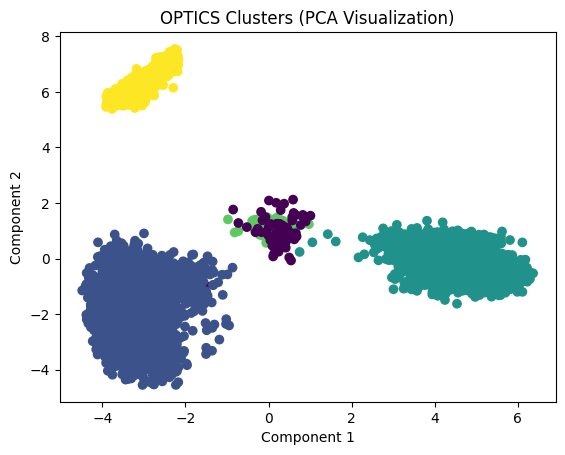

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a dictionary for mapping cluster labels to colors
color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed
colors = [color_map(label) for label in cluster_labels]

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(concatenated_data)


# Plot the reduced data with cluster labels as colors
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
plt.title('OPTICS Clusters (PCA Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


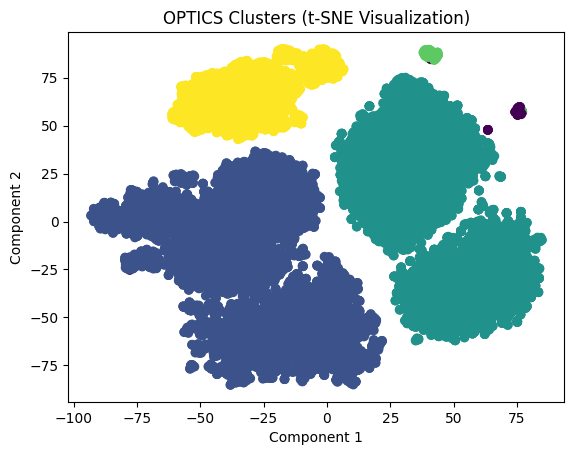

In [44]:
from sklearn.manifold import TSNE

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(concatenated_data)

# Plot the reduced data with cluster labels as colors
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
plt.title('OPTICS Clusters (t-SNE Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


<ipython-input-49-490760395bbf>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_embedding = torch.tensor(text_embedding)


textr:  (21469,)
kgr:  (21469,)
cluster:  (21469,)


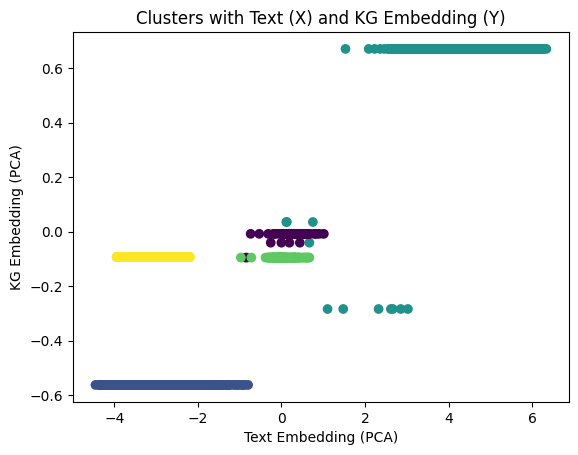

In [49]:
import pandas as pd
import torch
from torch import nn
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Separate text and kg embeddings for individual PCA
text_embeddings = df['text'].tolist()  # Assuming 'text' contains lists of tensors
kg_embeddings = df['embedding'].tolist()



# Apply attention to text embeddings before PCA
for i, text_embedding in enumerate(text_embeddings):
    text_embedding = torch.tensor(text_embedding)
    context_vector = attention_model(text_embedding)
    text_embeddings[i] = context_vector.detach().numpy()

# PCA for text embeddings
pca_text = PCA(n_components=1)
text_reduced = pca_text.fit_transform(text_embeddings)

# PCA for KG embeddings
pca_kg = PCA(n_components=1)
kg_reduced = pca_kg.fit_transform(kg_embeddings)

text_reduced = text_reduced.flatten()
kg_reduced = kg_reduced.flatten()
print("textr: ",text_reduced.shape)
print("kgr: ",kg_reduced.shape)
print("cluster: ",df['cluster'].shape)
# Create new DataFrame for plotting
plot_data = pd.DataFrame({
    'text': text_reduced,
    'embedding': kg_reduced,
    'cluster': df['cluster']
})

# Plot the results
plt.scatter(plot_data['text'], plot_data['embedding'], c=plot_data['cluster'])
plt.title('Clusters with Text (X) and KG Embedding (Y)')
plt.xlabel('Text Embedding (PCA)')
plt.ylabel('KG Embedding (PCA)')
plt.show()


In [52]:
df['cluster'] = cluster_labels
df.to_csv('clusterData.csv')

In [13]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# ... (Your code for SentenceAttention, data preparation, and OPTICS clustering)

# Prepare data for the neural network
text_embeddings = df['text'].to_numpy()  # Assuming 'text' contains lists of tensors
cluster_labels = df['cluster'].to_numpy()

# One-hot encode the cluster labels
encoder = OneHotEncoder(sparse=False)  # Dense representation
cluster_labels_encoded = encoder.fit_transform(cluster_labels.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings, cluster_labels_encoded, test_size=0.2, random_state=42
)


# Function to apply SentenceAttention to a batch of text embeddings
def apply_attention(text_batch, attention_model):
    context_vectors = []
    for text_embedding_list in text_batch:
        # Combine tensors within each row
        context_vector = attention_model(torch.tensor(text_embedding_list).to(device))
        context_vectors.append(context_vector)
    return torch.stack(context_vectors)
attention_model = SentenceAttention(768).to(device)

# Apply SentenceAttention to create context vectors
X_train = apply_attention(X_train, attention_model)
X_test = apply_attention(X_test, attention_model)

y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)
# Define the neural network model
class ClusterPredictor(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256).to(device)  # Adjust hidden size as needed
        self.linear2 = nn.Linear(256, 256).to(device)
        self.linear3 = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

# Initialize the model
input_size = 768  # Size of the context vector
num_classes = len(encoder.categories_[0])  # Number of unique clusters
clusterPredict = ClusterPredictor(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(clusterPredict.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    clusterPredict.train()
    outputs = clusterPredict(torch.tensor(X_train))
    loss = criterion(outputs, torch.max(y_train, 1)[1])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
      # Evaluate on the test set
      clusterPredict.eval()
      with torch.no_grad():
        test_outputs = clusterPredict(X_test)
        _, predicted = torch.max(test_outputs, 1)
        correct = (predicted == torch.max(y_test, 1)[1]).sum().item()
        accuracy = correct / len(X_test)
        print(f'Epoch {epoch+1}, Test Accuracy: {accuracy:.2f}')




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-13-947fdd2612b2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_vector = attention_model(torch.tensor(text_embedding_list).to(device))
<ipython-input-13-947fdd2612b2>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = clusterPredict(torch.tensor(X_train))


Epoch 1, Test Accuracy: 0.84
Epoch 11, Test Accuracy: 0.99
Epoch 21, Test Accuracy: 0.99
Epoch 31, Test Accuracy: 1.00
Epoch 41, Test Accuracy: 1.00


In [126]:
print(df['cluster'])

0        0
1        0
2        0
3        0
4        0
        ..
21464    1
21465    1
21466    1
21467    1
21468    1
Name: cluster, Length: 21469, dtype: int64


In [14]:
batch_size = 16
numEpochs = 20
latent_size = 2
def train_text_vae(model, dataloader, optimizer, epochs=10):
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        total_loss = 0
        for text_embeddings, cluster_labels in dataloader:
            if text_embeddings == None:
              continue
            text_embeddings = text_embeddings.to(device)

            optimizer.zero_grad()
            cluster_labels = cluster_labels.to(device)

            cluster_labels = cluster_labels.to(device)
            output, text_z, text_mu, text_logvar = model(text_embeddings, cluster_labels)
            attention_layer = SentenceAttention(768).to(device)  # Initialize attention
            context = attention_layer(text_embeddings)  # Apply attention
            # Calculate reconstruction and KL-Divergence loss
            # (you might need to adjust if a different loss is used)
            text_rc_loss = F.mse_loss(output, context)
            text_kl_loss = -0.5 * torch.sum(1 + text_logvar - text_mu.pow(2) - text_logvar.exp())

            loss = text_rc_loss + 1 * text_kl_loss  # Beta for KL weighting

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}: Training Loss - {avg_loss:.4f}')
    return text_z, textModel



import torch.utils.data.dataset as dataset
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(df['cluster'].to_numpy().reshape(-1, 1))  # Fit the encoder on cluster labels

class TextVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text_embedding = self.df.iloc[index]['text'].float()  # No concatenation
        cluster_label = self.df.iloc[index]['cluster']
        one_hot_cluster = encoder.transform([[cluster_label]]).flatten()
        one_hot_cluster = torch.tensor(one_hot_cluster).float()
        return text_embedding, one_hot_cluster

from torch.nn.utils.rnn import pad_sequence

# Updated collate function (no need for kg_embeddings)
def text_vae_collate_fn(batch):

    batch.sort(key=lambda x: len(x[0]), reverse=True)  # Sort by length
    text_embeddings = [item[0] for item in batch]  # Extract text embeddings
    cluster_labels = torch.stack([item[1] for item in batch]).float()
    # Pad the text embeddings
    text_embeddings_padded = pad_sequence(text_embeddings, batch_first=False)

    return text_embeddings_padded, cluster_labels

# Using the new dataset and collate function:
dataset_textvae = TextVAEDataset(df)
text_dataloader = DataLoader(
    dataset_textvae,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=text_vae_collate_fn,
)

textModel = TextVAE(
    bert_embedding_size=768,  # Adjust if using a different BERT model
    hidden_size=256,
    latent_size=latent_size,
    num_labels=len(encoder.categories_[0])
)
optimizer = optim.Adam(textModel.parameters())
text_zFinal, text_encoder_model = train_text_vae(textModel, text_dataloader, optimizer, epochs = numEpochs)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Training Loss - 0.2059
Epoch 2: Training Loss - 0.0266
Epoch 3: Training Loss - 0.0211
Epoch 4: Training Loss - 0.0214
Epoch 5: Training Loss - 0.0208
Epoch 6: Training Loss - 0.0209
Epoch 7: Training Loss - 0.0207
Epoch 8: Training Loss - 0.0204
Epoch 9: Training Loss - 0.0204
Epoch 10: Training Loss - 0.0203
Epoch 11: Training Loss - 0.0203
Epoch 12: Training Loss - 0.0201
Epoch 13: Training Loss - 0.0207
Epoch 14: Training Loss - 0.0204
Epoch 15: Training Loss - 0.0207
Epoch 16: Training Loss - 0.0205
Epoch 17: Training Loss - 0.0203
Epoch 18: Training Loss - 0.0201
Epoch 19: Training Loss - 0.0201
Epoch 20: Training Loss - 0.0201


In [183]:
del textModel

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore all UserWarnings

def train_kg_vae(model, dataloader, optimizer, num_epochs=10):
    model.train()  # Set the KGVAE model to training mode

    for epoch in range(num_epochs):
        total_loss = 0
        for kg_embeddings, cluster_labels in dataloader:
            if kg_embeddings == None:
              continue
            kg_embeddings = kg_embeddings.to(device)

            optimizer.zero_grad()

            kg_recon, kg_z, kg_mu, kg_logvar = model(kg_embeddings, cluster_labels)
            # Calculate reconstruction and KL-Divergence loss
            # (you might need to adjust if a different loss is used)
            kg_rc_loss = 1 - F.cosine_similarity(kg_recon, kg_embeddings, dim=-1).mean()
            kg_kl_loss = -0.5 * torch.sum(1 + kg_logvar - kg_mu.pow(2) - kg_logvar.exp())

            loss = kg_rc_loss + 1 * kg_kl_loss  # Beta for KL weighting

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}: KGVAE Training Loss - {avg_loss:.4f}')
    return kg_z, model_kgvae



class KGVAEDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        kg_embedding = self.df.iloc[index]['embedding']
        kg_embedding_tensor = torch.tensor(kg_embedding).float()
        cluster_label = self.df.iloc[index]['cluster']
        one_hot_cluster = encoder.transform([[cluster_label]]).flatten()
        one_hot_cluster = torch.tensor(one_hot_cluster).float()

        return kg_embedding_tensor, one_hot_cluster

def kg_vae_collate_fn(batch):
    kg_embeddings = [item[0] for item in batch]
    kg_embeddings = torch.stack(kg_embeddings)

    # Convert cluster labels to tensors
    cluster_labels = [item[1] for item in batch]
    cluster_labels = torch.stack(cluster_labels).float()

    return kg_embeddings.to(device), cluster_labels.to(device)



dataset_kgvae = KGVAEDataset(df)
kg_dataloader = DataLoader(
    dataset_kgvae,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=kg_vae_collate_fn
)

model_kgvae = KGVAE(
    kg_embedding_size=300,  # Adjust according to your KG embeddings
    hidden_size=256,
    latent_size=latent_size,
    num_labels=len(encoder.categories_[0])
).to(device)
optimizer_kgvae = optim.Adam(model_kgvae.parameters(), lr=0.0005)  # Adjust learning rate as needed


kg_zFinal, kgDecoder = train_kg_vae(model_kgvae, kg_dataloader, optimizer_kgvae, num_epochs = numEpochs)

kg_zFinal = kg_zFinal.detach().to(device)
del model_kgvae

text_zFinal = text_zFinal.detach().to(device)
del textModel

Epoch 1: KGVAE Training Loss - 0.0313
Epoch 2: KGVAE Training Loss - 0.0010
Epoch 3: KGVAE Training Loss - 0.0008
Epoch 4: KGVAE Training Loss - 0.0009
Epoch 5: KGVAE Training Loss - 0.0008
Epoch 6: KGVAE Training Loss - 0.0009
Epoch 7: KGVAE Training Loss - 0.0007
Epoch 8: KGVAE Training Loss - 0.0008
Epoch 9: KGVAE Training Loss - 0.0008
Epoch 10: KGVAE Training Loss - 0.0007
Epoch 11: KGVAE Training Loss - 0.0007
Epoch 12: KGVAE Training Loss - 0.0007
Epoch 13: KGVAE Training Loss - 0.0007
Epoch 14: KGVAE Training Loss - 0.0008
Epoch 15: KGVAE Training Loss - 0.0008
Epoch 16: KGVAE Training Loss - 0.0007
Epoch 17: KGVAE Training Loss - 0.0008
Epoch 18: KGVAE Training Loss - 0.0007
Epoch 19: KGVAE Training Loss - 0.0007
Epoch 20: KGVAE Training Loss - 0.0007


In [ ]:
import math
def train_vae_on_cluster(model, dataloader, optimizer, cluster_id, num_epochs=25):
    """Trains either TextVAE or KGVAE on a specific cluster."""
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for embeddings in dataloader:
            torch.nn.utils.clip_grad_norm_(text_model.parameters(), 1)
            if embeddings is None:
                continue

            if isinstance(model, TextVAE):
              embeddings=embeddings[0].to(device)
            else:
              embeddings=embeddings[1].to(device)
            output, z, mu, logvar = model(embeddings)
            if isinstance(model, TextVAE):  # TextVAE Loss
                attention_layer = SentenceAttention(768).to(device)
                context = attention_layer(embeddings)
                rc_loss = F.mse_loss(output, context)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = rc_loss + 1 * kl_loss  # Adjust weighting if needed
                if math.isnan(loss):
                  print("Real: ",context)
                  print("generated: ",output)
                  print("rc_loss: ",rc_loss)
                  print("kl_loss: ",kl_loss)

            elif isinstance(model, KGVAE):  # KGVAE Loss
                rc_loss = 1 - F.cosine_similarity(output, embeddings, dim=-1).mean()
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = rc_loss + 1 * kl_loss  # Adjust weighting if needed

            else:
                raise ValueError("Model must be either TextVAE or KGVAE")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if len(dataloader) != 0:
          avg_loss = total_loss / len(dataloader)
          print(f'Epoch {epoch+1} (Cluster {cluster_id}): Training Loss - {avg_loss:.4f}')

    return z, model.encoder if isinstance(model, TextVAE) else model.decoder



# **1. Create Data Loaders for each Cluster**
def create_cluster_dataloaders(df, cluster_labels):
    cluster_dataloaders = {}
    for cluster_id in set(cluster_labels):
        cluster_df = df[df['cluster'] == cluster_id]

        text_dataset = TextVAEDataset(cluster_df)
        text_dataloader = DataLoader(
            text_dataset, batch_size=batch_size, shuffle=True, collate_fn=text_vae_collate_fn
        )
        cluster_dataloaders[cluster_id] = {'text': text_dataloader}

        kg_dataset = KGVAEDataset(cluster_df)
        kg_dataloader = DataLoader(
            kg_dataset, batch_size=batch_size, shuffle=True, collate_fn=kg_vae_collate_fn
        )
        cluster_dataloaders[cluster_id]['kg'] = kg_dataloader

    return cluster_dataloaders

# **2. Train VAEs on each Cluster and Store Results**
cluster_dataloaders = create_cluster_dataloaders(df, cluster_labels)  # From OPTICS
database = []  # To store cluster, TextVAE z, and KGVAE z

for cluster_id, dataloaders in cluster_dataloaders.items():
    # Train TextVAE
    text_model = TextVAE(bert_embedding_size=768, hidden_size=256, latent_size=latent_size).to(device)
    text_optimizer = optim.Adam(text_model.parameters(), lr=0.00005)
    torch.nn.utils.clip_grad_norm_(text_model.parameters(), 1)
    print("TextVAE: ",cluster_id)
    text_z, text_encoder = train_vae_on_cluster(
        text_model, dataloaders['text'], text_optimizer, cluster_id
    )

    # Train KGVAE
    kg_model = KGVAE(kg_embedding_size=300, hidden_size=256, latent_size=latent_size).to(device)
    kg_optimizer = optim.Adam(kg_model.parameters(), lr=0.00005)
    torch.nn.utils.clip_grad_norm_(kg_model.parameters(), 1)
    print("KGVAE: ",cluster_id)
    kg_z, kg_decoder = train_vae_on_cluster(
       kg_model, dataloaders['kg'], kg_optimizer, cluster_id
    )

    # Store in database
    database.append({
        'cluster': cluster_id,
        'text_z': text_z.tolist(),  # Convert to list for storage
        'kg_z': kg_z.tolist()
    })

database.append({
    'cluster' : -1,
    'text_z': text_zFinal,
    'kg_z' : kg_zFinal
})

# **3. Create DataFrame from Database **
cluster_db_df = pd.DataFrame(database)

TextVAE:  0
Epoch 1 (Cluster 0): Training Loss - 1.4202


In [ ]:
cluster_db_df.to_csv('zs.csv')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

noise_dim = latent_size

# Instantiate Generator and Discriminator
generator = Generator(latent_size, 16).to(device)
discriminator = Discriminator(latent_size).to(device)

optimizer_generator = optim.Adam(generator.parameters())
optimizer_discriminator = optim.Adam(discriminator.parameters())
criterion = nn.BCEWithLogitsLoss()  # Standard for GANs


# Hyperparameters
epochs = 100
batch_size = 32
num_clusters = cluster_db_df['cluster'].nunique()

# Data preparation (assuming cluster_db_df is your DataFrame)
cluster_data = cluster_db_df.to_numpy()  # Convert into an array for shuffling
np.random.shuffle(cluster_data)

# GAN Training Loop
for epoch in range(epochs):
    for i in range(0, len(cluster_data), batch_size):
        batch_data = cluster_data[i:i+batch_size]
        batch_df = pd.DataFrame(batch_data, columns=['cluster', 'text_z', 'kg_z'])

        # Sample from the batch
        z_text = torch.tensor(batch_df['text_z'].tolist()).to(device)
        kg_z = torch.tensor(batch_df['kg_z'].tolist()).to(device)

        # Cluster labels for conditioning
        cluster_labels = torch.tensor(batch_df['cluster'].to_numpy()).to(device)

        # Generator training step
        optimizer_generator.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_kg_z = generator(z_text, noise)
        d_on_fake = discriminator(fake_kg_z.detach())
        target_fake = torch.ones_like(d_on_fake)
        g_loss = criterion(d_on_fake, target_fake)
        g_loss.backward()
        optimizer_generator.step()

        # Discriminator training step
        optimizer_discriminator.zero_grad()
        d_real = discriminator(kg_z.detach())
        target_real = torch.ones_like(d_real)
        d_loss_real = criterion(d_real, target_real)

        d_fake = discriminator(fake_kg_z.detach())
        target_fake = torch.zeros_like(d_fake)
        d_loss_fake = criterion(d_fake, target_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_discriminator.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}: Generator Loss - {g_loss:.4f} : Discriminator Loss - {d_loss:.4f}')

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence


def text_embedding(texts):
    text_embeddings =[]
    for query_text in input_texts:
      inputs = tokenizer(query_text, padding=True, truncation=True, return_tensors="pt")
      outputs = model1(**inputs)
      text_embedding = outputs.last_hidden_state[:, 0, :].to(device)  # CLS Token Embedding
      text_embeddings.append(text_embedding)
    return torch.stack(text_embeddings)



# **Example Usage**
input_texts = [
    "The vast grasslands of the [[African savanna]] support diverse wildlife.",
    "[[animal]] is the opposite of [[bird]]', '[[animal]] is the opposite of [[human]]', '[[animal]] is the opposite of [[human plants]]', '[[animal]] is the opposite of [[man]]', '[[animal]] is the opposite of [[mineral]]'",
    "[[Renaissance art]] emphasized [[classical forms]] and [[humanism]].",
    "The intricate patterns of [[fractals]] reveal mathematical beauty.",
    "The [[economic policies]] of the [[1980s]] had a lasting global impact.",
    "[[Ancient mythology]] provides insights into the beliefs of early [[civilizations]].",
    "The development of [[vaccines]] revolutionized modern medicine.",
    "The [[human brain]] processes information with incredible complexity."
    "Name a large [[country]] in [[America]].",
    "What is the name of a [[tall mountain range]] in [[Europe]]?",
    "What is a soft-fleeced [[animal]] related to the camel?",
    "What is the [[chemical symbol]] for [[gold]]?",
    "What is the largest [[organ]] in the [[human body]]? ",
    "Which ancient [[civilization]] built the [[pyramids]]?",
    "Which famous [[Greek philosopher]] was the [[teacher]] of [[Alexander the Great]]?",
    "What is the [[capital city]] of [[France]]?",
    "What is the capital of France?",
    "Who was the 22nd president?",
    "Who fought the bravest in the eastern front of WW2?",
    "Who was the most sadistic figure in history?",
    "Which straight public figure was actually homosexual?",
    "Flying high in april and shot down in may",
    "Gubernatorial woman",
    "all your friends are being outcompeted in Piston Cup",
    "The deep trenches of the [[Pacific Ocean]] are home to unique and mysterious creatures.",
    "[[Mars]] is often referred to as the [[Red Planet]] due to its surface color.",
    "The [[Renaissance period]] was marked by the revival of [[classical learning]] and wisdom.",
    "The principles of [[quantum mechanics]] challenge our understanding of [[reality]].",
    "The [[industrial revolution]] dramatically changed societies around the world.",
    "Exploring ancient [[ruins]] offers a glimpse into past [[civilizations]].",
    "The invention of the [[internet]] has transformed global communication.",
    "The [[human genome]] contains the blueprint for building a person.",
    "Name a country known for its [[ancient ruins]] in [[South America]].",
    "What is the name of the [[deepest ocean trench]]?",
    "What animal is known as the [[king of the jungle]]?",
    "What is the [[chemical symbol]] for [[oxygen]]?",
    "What is the smallest [[bone]] in the [[human body]]?",
    "Which [[civilization]] invented [[writing]]?",
    "Who was a famous [[Roman philosopher]] known for his meditations?",
    "What is the [[capital city]] of [[Japan]]?",
    "What is the tallest [[mountain]] in the world?",
    "Who was the first [[woman]] in space?",
    "Which country was the first to implement [[democracy]]?",
    "Who is considered the father of [[modern physics]]?",
    "What historical event is known as the [[Great Fire]] of London?",
    "The phrase 'I think, therefore I am' was coined by which [[philosopher]]?",
    "Which [[organism]] is known to live the longest?",
    "What is the main ingredient in [[traditional Italian pizza dough]]?",
    "Name a country in Africa that borders the Mediterranean Sea.",
    "What is the capital of the smallest country in South America?",
    "What large desert is found in northern China and Mongolia?"
]

text_embeddings = text_embedding(input_texts)

In [ ]:
with torch.no_grad():
    pred_clusters = clusterPredict(text_embeddings)
    print("pred_clusters: ",pred_clusters.shape())
    output, z_text2, mu, logvar = text_encoder_model(text_embeddings,pred_clusters)
    print("textVAE: ",z_text2.shape)
    print(z_text2)
    noise = torch.randn(len(text_embeddings), noise_dim).to(device)
    print(pred_clusters)
    output = generator(z_text2, noise,pred_clusters)
    print("Generator: ",output.shape)
    print(output)
    output = kgDecoder(output,pred_clusters,True)
    print("kgVAE: ",output)
    print(output.shape)
    print(output)

In [28]:
print(output)

tensor([[[ 0.8563,  0.5031, -5.1106,  ...,  3.1372, -2.0765, -0.6397]],

        [[ 1.1766,  0.7233, -6.9593,  ...,  4.2933, -2.7650, -0.8817]],

        [[ 1.1313,  0.6816, -6.6980,  ...,  4.1449, -2.6829, -0.8759]],

        ...,

        [[ 0.9828,  0.5775, -5.6951,  ...,  3.5325, -2.2821, -0.7345]],

        [[ 0.7487,  0.4458, -4.5216,  ...,  2.7731, -1.8405, -0.5475]],

        [[ 0.9645,  0.5989, -5.8459,  ...,  3.5890, -2.3421, -0.7158]]],
       device='cuda:0')


In [ ]:
i=0
for embedding in output:
  distances = F.cosine_similarity(embedding, torch.Tensor(embeddings).to(device), dim=-1)
  # Find the top 5 closest entities
  top_5_indices = torch.topk(distances, k=5).indices
  print(f"Query: {input_texts[i]}")
  print("Closest Entities:")
  i=i+1
  for concept_idx in top_5_indices:
    concept_label = vocabulary[concept_idx.item()]
    distance = distances[concept_idx.item()].item()  # Get float value
    print(f"  - Concept Label: {concept_label} (Similarity: {distance:.4f})")
    print("---") # Separator between queries

In [ ]:
print(beta)

1


In [ ]:
import torch.utils.data.dataset as dataset
device = torch.device("cuda")
class WikiDataset(dataset.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Flatten text embeddings into a single tensor
        text_embeddings = torch.cat([self.df.iloc[index]['text']]).float()
        torch.stack
        # Convert kg_embedding to a PyTorch tensor
        kg_embedding = torch.tensor(self.df.iloc[index]['embedding']).float()
        return text_embeddings, kg_embedding




In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
device = torch.device("cuda")
class SentenceAttention(nn.Module):
    def __init__(self, attention_hidden_size):
        super().__init__()
        self.linear = nn.Linear(attention_hidden_size, attention_hidden_size)

    def forward(self, encoder_outputs):
      # Transform x using a linear layer; output shape will be (sq, b, hidden_size)
      x_transformed = self.linear(encoder_outputs)
      # Step 2: Compute attention scores using softmax across the sequence dimension (sq)
      # Attention scores shape: (sq, b, hidden_size) -> (b, sq, hidden_size) for softmax
      x_transposed = x_transformed.transpose(0, 1)  # Transposing for softmax operation
      attention_scores = F.softmax(x_transposed, dim=1)  # Applying softmax; shape remains (b, sq, hidden_size)

      # Step 3: Apply attention scores to the original input tensor
      # For weighted sum, first transpose x back: (sq, b, hidden_size) -> (b, sq, hidden_size)
      x = encoder_outputs.transpose(0, 1)  # Transposing x to match attention_scores shape
      # Compute the context vector as the weighted sum of the input vectors
      # (b, sq, hidden_size) * (b, sq, hidden_size) -> (b, hidden_size) after summing over sq dimension
      context_vector = torch.sum(attention_scores * x, dim=1)
      return context_vector
# **1. Text Encoder**
class TextEncoder(nn.Module):
    def __init__(self, bert_embedding_size, encoder_hidden_size, latent_size):
        super().__init__()
        self.encoder_size = encoder_hidden_size
        self.bert_size = bert_embedding_size
        # Transformer Encoder Layer Configuration
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=bert_embedding_size,
            nhead=8,  # Number of attention heads
            dim_feedforward=encoder_hidden_size, # Dim. of feedforward network
            batch_first=False
        )

        # Stack Multiple Transformer Layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=5)
        self.linear1 = nn.Linear(bert_embedding_size, encoder_hidden_size)
        self.linear2 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear3 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear4 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear5 = nn.Linear(encoder_hidden_size, latent_size)
        self.linear_mu = nn.Linear(latent_size, latent_size)
        self.linear_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, text_embeddings):
      out = self.transformer_encoder(text_embeddings)
      attention_layer = SentenceAttention(self.bert_size).to(device)  # Initialize attention
      context = attention_layer(out)  # Apply attention
      # Rest of your encoder layers
      out = torch.relu(self.linear1(context))
      out = torch.relu(self.linear2(out))
      out = torch.relu(self.linear3(out))
      out = torch.relu(self.linear4(out))
      out = torch.relu(self.linear5(out))


      mu = self.linear_mu(out)
      logvar = self.linear_logvar(out)

      # Reparameterization trick for backpropagation through sampling
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      z = eps.mul(std).add_(mu)  # Sample from the latent distribution
      return z, mu, logvar

# **2. Knowledge Graph Embedding Decoder**
class KGDecoder(nn.Module):
    def __init__(self, latent_size, decoder_hidden_size, kg_embedding_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, decoder_hidden_size)
        self.linear2 = nn.Linear(decoder_hidden_size, decoder_hidden_size)  # Additional layers
        self.output_layer = nn.Linear(decoder_hidden_size, kg_embedding_size)

    def forward(self, z):
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, latent_size):
         super().__init__()
         self.linear1 = nn.Linear(latent_size, 128)
         self.linear2 = nn.Linear(128, 64)
         self.output_layer = nn.Linear(64, 1)

    def forward(self, z):
         out = torch.relu(self.linear1(z))
         out = torch.relu(self.linear2(out))
         out = self.output_layer(out)
         return out



# **3. Model, Loss, and Training**
class HybridVAE(nn.Module):
    def __init__(self, text_encoder, kg_decoder, beta=1.0, gamma=1.0):
        super().__init__()
        self.text_encoder = text_encoder
        self.kg_decoder = kg_decoder
        self.beta = beta
        self.gamma = gamma

    def forward(self, text_embeddings):
        z, mu, logvar = self.text_encoder(text_embeddings)
        kg_embeddings_pred = self.kg_decoder(z)
        return kg_embeddings_pred, mu, logvar







# **Modified Loss Function**
def loss_function(kg_embeddings_pred, kg_embeddings,z, mu, logvar, beta=1.0, gamma=1.0):
    # Cosine Similarity Calculation
    cosine_similarity = F.cosine_similarity(kg_embeddings_pred, kg_embeddings, dim=-1)

    # Cosine Distance (1 - Cosine Similarity)
    cosine_distance = 1 - cosine_similarity

    # MSE Calculation

    reconstruction_loss = torch.mean(cosine_distance)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Correlation (TC) Penalty
    cov_z = torch.cov(z.T)  # Covariance matrix of the latent representations
    tc_loss = (cov_z.diagonal() - cov_z).sum()  # Focus on off-diagonal elements
    #print("rc: ",reconstruction_loss)
    #print("kl: ",beta * kl_divergence)
    #print("tc: ",gamma * tc_loss)
    # Combined Loss
    loss = reconstruction_loss + beta * kl_divergence + gamma * tc_loss

    return loss




import torch
from torch.nn.utils.rnn import pad_sequence
import random


def dynamic_collate_fn(batch):
    """
    Custom collate function for dynamic batching, handling variable-length text sequences.

    Args:
        batch: A list of tuples (text_embeddings, kg_embedding) from the dataset.

    Returns:
        text_embeddings_padded: Padded tensor of text embeddings.
        kg_embeddings: Stacked tensor of KG embeddings.
        lengths: Original lengths of text sequences before padding.
    """

    # Sort data by descending length of text sequences (for efficient padding)
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    # Unpack data
    text_embeddings_list, kg_embeddings = zip(*batch)

    # Pad text embeddings
    text_embeddings_padded = pad_sequence(text_embeddings_list, batch_first=False)

    # Stack KG embeddings directly
    kg_embeddings = torch.stack(kg_embeddings)


    return text_embeddings_padded, kg_embeddings



dataset = WikiDataset(df)
batch_size1 = 16
# Create the DataLoader with dynamic batching
dataloader = DataLoader(
    dataset,
    batch_size=batch_size1,
    shuffle=True,  # Shuffle before each epoch
    collate_fn=dynamic_collate_fn
)
latent_size1=8
# Instantiate models (adjust hyperparameters)
text_encoder = TextEncoder(bert_embedding_size=768,  # If using BERT-base,
                           encoder_hidden_size=64,
                           latent_size=latent_size1)

kg_decoder = KGDecoder(latent_size=latent_size1,
                       decoder_hidden_size=64,
                       kg_embedding_size=300)

model = HybridVAE(text_encoder, kg_decoder,beta=0.75,gamma=0.000001).to(device)  # Clean instantiation
from torch.optim.lr_scheduler import ReduceLROnPlateau
# **Training Loop**
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.25, patience=10)

discriminator = Discriminator(latent_size1).to(device)  # Assuming your Discriminator class is defined
optimizer_discriminator = optim.Adam(discriminator.parameters())  # Or a suitable optimizer of your choice
criterion_D = nn.BCEWithLogitsLoss()

import torch

def sample_from_marginals(z):
    """
    Samples from marginal distributions with an emphasis on diverse cosine similarities.

    Args:
        z: The latent code tensor (batch_size, latent_size)

    Returns:
        marginal_samples: A tensor of the same shape as z, with samples encouraging
                          a wider range of cosine similarities.
    """

    batch_size, latent_size = z.shape
    marginal_means = z.mean(dim=0)

    # Multiplier to increase the influence of cosine similarity
    cosine_sim_multiplier = 0.25  # Adjust this as needed

    marginal_samples = torch.zeros_like(z)
    for i in range(latent_size):
        # Similarities with the current dimension as the anchor
        similarities = F.cosine_similarity(z[:, i].unsqueeze(1), z, dim=0)

        # Increase the distance from similar samples
        sim_adjusted = similarities * cosine_sim_multiplier
        modified_std = torch.std(sim_adjusted)  # Std of adjusted similarities

        marginal_samples[:, i] = torch.normal(marginal_means[i], modified_std)

    return marginal_samples


for epoch in range(500):
    total_loss = 0

    # Training Phase
    i = 0
    k = 0
    p = 0
    for text_embeddings_packed, kg_embeddings in dataloader:
        p=p+1
        text_embeddings_packed = text_embeddings_packed.to(device)
        kg_embeddings = kg_embeddings.to(device)
        i=i+batch_size1
        if i>=5000:
          k=k+1
          print("i: ",i*k)
          i=0
        optimizer.zero_grad()
        # Encoding
        z, mu, logvar = model.text_encoder(text_embeddings_packed)
        # Decoding
        kg_embeddings_pred = model.kg_decoder(z)

        # Loss Calculation
        loss = loss_function(kg_embeddings_pred, kg_embeddings, z, mu, logvar,model.beta,model.gamma)


        for _ in range(20): # Train discriminator multiple times per encoder/decoder update
          optimizer_discriminator.zero_grad()
          # Real samples
          real_samples = z.detach()  # Detach to avoid gradient backprop through encoder
          d_real = discriminator(real_samples)
          target_real = torch.ones_like(d_real)
          # Fake samples (by sampling from marginals)
          marginal_samples = sample_from_marginals(z)  # You'll need to implement this function
          d_fake = discriminator(marginal_samples)
          target_fake = torch.zeros_like(d_fake)
          # Discriminator loss
          d_loss = criterion_D(d_real, target_real)  + criterion_D(d_fake, target_fake)

          d_loss.backward(retain_graph=True)
          optimizer_discriminator.step()
        # --- Adversarial Loss for VAE ---
        d_on_z = discriminator(z)  # Discriminator's output on the encoded z
        target_real_vae = torch.ones_like(d_on_z)  # Target "real" for the VAE
        adversarial_loss = criterion_D(d_on_z, target_real_vae)

        # Total VAE Loss
        total_loss_VAE = loss +  adversarial_loss  # lambda_adv controls adversarial weighting
        total_loss_VAE.backward()
        optimizer.step()
        total_loss += total_loss_VAE.item()  # Add to epoch loss



    # Print epoch information
    epoch_loss = total_loss / p
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}: Training Loss - {epoch_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-6-81ab89947052>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kg_embedding = torch.tensor(self.df.iloc[index]['embedding']).float()


i:  5008
i:  10016
i:  15024
i:  20032
Epoch 1: Training Loss - 0.3579
i:  5008
i:  10016
i:  15024
i:  20032
Epoch 2: Training Loss - 0.2686
i:  5008
i:  10016
i:  15024
i:  20032
Epoch 3: Training Loss - 0.2701
i:  5008
i:  10016
i:  15024
i:  20032
Epoch 4: Training Loss - 0.2735
i:  5008
i:  10016
i:  15024
i:  20032
Epoch 5: Training Loss - 0.2775


KeyboardInterrupt: 

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F

# **Inference Function**
def find_closest_entities(model, input_texts, embeddings, vocabulary, tokenizer, bert_model):
    """
    Finds the closest entities in ConceptNet embeddings for a list of input texts.

    Args:
        model (HybridVAE): The trained HybridVAE model.
        input_texts (list): A list of input text descriptions.
        embeddings (np.array): The ConceptNet embeddings array.
        vocabulary (list): The vocabulary of concept labels.
        tokenizer (BertTokenizer): The BERT tokenizer.
        bert_model (BertModel): The BERT language model.

    Returns:
        None (Prints the results directly).
    """

    for query_text in input_texts:
        with torch.no_grad():
            # Encode the text input
            inputs = tokenizer(query_text, padding=True, truncation=True, return_tensors="pt")
            outputs = bert_model(**inputs)
            text_embedding = outputs.last_hidden_state[:, 0, :].to(device)  # CLS Token Embedding

            # Process through the text encoder
            z, _, _ = model.text_encoder(text_embedding.unsqueeze(dim=0))  # Add a dimension for batch

            # Decode to get a representation
            predicted_embedding = model.kg_decoder(z).squeeze(dim=0)
            print("Predicted Embedding (first 5 elements):", predicted_embedding[:5])
            # Calculate cosine similarities against ConceptNet embeddings
            distances = F.cosine_similarity(predicted_embedding, torch.Tensor(embeddings).to(device), dim=-1)

            # Find the top 5 closest entities
            top_5_indices = torch.topk(distances, k=5).indices

            print(f"Query: {query_text}")
            print("Closest Entities:")

            for concept_idx in top_5_indices:
                concept_label = vocabulary[concept_idx.item()]
                distance = distances[concept_idx.item()].item()  # Get float value
                print(f"  - Concept Label: {concept_label} (Distance: {distance:.4f})")
            print("---") # Separator between queries

# **Example Usage**
input_texts = [
    "The vast grasslands of the [[African savanna]] support diverse wildlife.",
    "[[animal]] is the opposite of [[bird]]', '[[animal]] is the opposite of [[human]]', '[[animal]] is the opposite of [[human plants]]', '[[animal]] is the opposite of [[man]]', '[[animal]] is the opposite of [[mineral]]'",
    "[[Renaissance art]] emphasized [[classical forms]] and [[humanism]].",
    "The intricate patterns of [[fractals]] reveal mathematical beauty.",
    "The [[economic policies]] of the [[1980s]] had a lasting global impact.",
    "[[Ancient mythology]] provides insights into the beliefs of early [[civilizations]].",
    "The development of [[vaccines]] revolutionized modern medicine.",
    "The [[human brain]] processes information with incredible complexity."
    "Name a large [[country]] in [[America]].",
    "What is the name of a [[tall mountain range]] in [[Europe]]?",
    "What is a soft-fleeced [[animal]] related to the camel?",
    "What is the [[chemical symbol]] for [[gold]]?",
    "What is the largest [[organ]] in the [[human body]]? ",
    "Which ancient [[civilization]] built the [[pyramids]]?",
    "Which famous [[Greek philosopher]] was the [[teacher]] of [[Alexander the Great]]?",
    "What is the [[capital city]] of [[France]]?",
    "What is the capital of France?",
    "Who was the 22nd president?",
    "Who fought the bravest in the eastern front of WW2?",
    "Who was the most sadistic figure in history?",
    "Which straight public figure was actually homosexual?",
    "Flying high in april and shot down in may",
    "Gubernatorial woman",
    "all your friends are being outcompeted in Piston Cup",
    "The deep trenches of the [[Pacific Ocean]] are home to unique and mysterious creatures.",
    "[[Mars]] is often referred to as the [[Red Planet]] due to its surface color.",
    "The [[Renaissance period]] was marked by the revival of [[classical learning]] and wisdom.",
    "The principles of [[quantum mechanics]] challenge our understanding of [[reality]].",
    "The [[industrial revolution]] dramatically changed societies around the world.",
    "Exploring ancient [[ruins]] offers a glimpse into past [[civilizations]].",
    "The invention of the [[internet]] has transformed global communication.",
    "The [[human genome]] contains the blueprint for building a person.",
    "Name a country known for its [[ancient ruins]] in [[South America]].",
    "What is the name of the [[deepest ocean trench]]?",
    "What animal is known as the [[king of the jungle]]?",
    "What is the [[chemical symbol]] for [[oxygen]]?",
    "What is the smallest [[bone]] in the [[human body]]?",
    "Which [[civilization]] invented [[writing]]?",
    "Who was a famous [[Roman philosopher]] known for his meditations?",
    "What is the [[capital city]] of [[Japan]]?",
    "What is the tallest [[mountain]] in the world?",
    "Who was the first [[woman]] in space?",
    "Which country was the first to implement [[democracy]]?",
    "Who is considered the father of [[modern physics]]?",
    "What historical event is known as the [[Great Fire]] of London?",
    "The phrase 'I think, therefore I am' was coined by which [[philosopher]]?",
    "Which [[organism]] is known to live the longest?",
    "What is the main ingredient in [[traditional Italian pizza dough]]?",
    "Name a country in Africa that borders the Mediterranean Sea.",
    "What is the capital of the smallest country in South America?",
    "What large desert is found in northern China and Mongolia?"
]

find_closest_entities(model, input_texts, embeddings, vocabulary, tokenizer, model1)


Predicted Embedding (first 5 elements): tensor([ 17.6128,   9.5389, -99.3306,  42.5649, -31.4522], device='cuda:0')
Query: The vast grasslands of the [[African savanna]] support diverse wildlife.
Closest Entities:
  - Concept Label: en (Distance: 0.8151)
  - Concept Label: pt (Distance: 0.7337)
  - Concept Label: es (Distance: 0.6359)
  - Concept Label: nut_quad (Distance: 0.6091)
  - Concept Label: en_quad (Distance: 0.6049)
---
Predicted Embedding (first 5 elements): tensor([ 15.7203,   8.5225, -88.6922,  38.0044, -28.0769], device='cuda:0')
Query: [[animal]] is the opposite of [[bird]]', '[[animal]] is the opposite of [[human]]', '[[animal]] is the opposite of [[human plants]]', '[[animal]] is the opposite of [[man]]', '[[animal]] is the opposite of [[mineral]]'
Closest Entities:
  - Concept Label: en (Distance: 0.8151)
  - Concept Label: pt (Distance: 0.7337)
  - Concept Label: es (Distance: 0.6359)
  - Concept Label: nut_quad (Distance: 0.6091)
  - Concept Label: en_quad (Distance

In [ ]:
from torch.nn.utils.rnn import pad_sequence
# *** Placeholders for your 8 input queries ***
input_queries = [
    "The vast grasslands of the [[African savanna]] support diverse wildlife.",
    "[[animal]] is the opposite of [[bird]]', '[[animal]] is the opposite of [[human]]', '[[animal]] is the opposite of [[human plants]]', '[[animal]] is the opposite of [[man]]', '[[animal]] is the opposite of [[mineral]]'",
    "[[Renaissance art]] emphasized [[classical forms]] and [[humanism]].",
    "The intricate patterns of [[fractals]] reveal mathematical beauty.",
    "The [[economic policies]] of the [[1980s]] had a lasting global impact.",
    "[[Ancient mythology]] provides insights into the beliefs of early [[civilizations]].",
    "The development of [[vaccines]] revolutionized modern medicine.",
    "The [[human brain]] processes information with incredible complexity."
    "Name a large [[country]] in [[America]].",
    "What is the name of a [[tall mountain range]] in [[Europe]]?",
    "What is a soft-fleeced [[animal]] related to the camel?",
    "What is the [[chemical symbol]] for [[gold]]?",
    "What is the largest [[organ]] in the [[human body]]? ",
    "Which ancient [[civilization]] built the [[pyramids]]?",
    "Which famous [[Greek philosopher]] was the [[teacher]] of [[Alexander the Great]]?",
    "What is the [[capital city]] of [[France]]?",
    "What is the capital of France?",
    "Who was the 22nd president?",
    "Who fought the bravest in the eastern front of WW2?",
    "Who was the most sadistic figure in history?",
    "Which straight public figure was actually homosexual?",
    "Flying high in april and shot down in may",
    "Gubernatorial woman",
    "all your friends are being outcompeted in Piston Cup",
    "The deep trenches of the [[Pacific Ocean]] are home to unique and mysterious creatures.",
    "[[Mars]] is often referred to as the [[Red Planet]] due to its surface color.",
    "The [[Renaissance period]] was marked by the revival of [[classical learning]] and wisdom.",
    "The principles of [[quantum mechanics]] challenge our understanding of [[reality]].",
    "The [[industrial revolution]] dramatically changed societies around the world.",
    "Exploring ancient [[ruins]] offers a glimpse into past [[civilizations]].",
    "The invention of the [[internet]] has transformed global communication.",
    "The [[human genome]] contains the blueprint for building a person.",
    "Name a country known for its [[ancient ruins]] in [[South America]].",
    "What is the name of the [[deepest ocean trench]]?",
    "What animal is known as the [[king of the jungle]]?",
    "What is the [[chemical symbol]] for [[oxygen]]?",
    "What is the smallest [[bone]] in the [[human body]]?",
    "Which [[civilization]] invented [[writing]]?",
    "Who was a famous [[Roman philosopher]] known for his meditations?",
    "What is the [[capital city]] of [[Japan]]?",
    "What is the tallest [[mountain]] in the world?",
    "Who was the first [[woman]] in space?",
    "Which country was the first to implement [[democracy]]?",
    "Who is considered the father of [[modern physics]]?",
    "What historical event is known as the [[Great Fire]] of London?",
    "The phrase 'I think, therefore I am' was coined by which [[philosopher]]?",
    "Which [[organism]] is known to live the longest?",
    "What is the main ingredient in [[traditional Italian pizza dough]]?",
    "Name a country in Africa that borders the Mediterranean Sea.",
    "What is the capital of the smallest country in South America?",
    "What large desert is found in northern China and Mongolia?"
]



# Encode input queries using BERT and HybridVAE

with torch.no_grad():
  encoded_queries = []
  max_length = 0  # Initialize max_length
  for query in input_queries:
    inputs = tokenizer(query, return_tensors="pt")
    attention_mask = inputs.pop('attention_mask')
    max_length = max(max_length, attention_mask.shape[-1])

    outputs = model1(**inputs)
    token_embeddings = outputs.last_hidden_state[:,0,:]
    #print(token_embeddings.shape)
    #print(token_embeddings.squeeze(0).shape)
    encoded_queries.append(token_embeddings)
  padded_queries = pad_sequence(encoded_queries, batch_first=False, padding_value=0)
  print(padded_queries)
  text_embeddings = padded_queries
  print(text_embeddings.shape)


  # VAE Encoding
  latent_embeddings, _, _  = model.text_encoder(text_embeddings)
  print(latent_embeddings.shape)

  # VAE Decoding
  kg_embeddings = model.kg_decoder(latent_embeddings)
  kg_embeddings_np = kg_embeddings.numpy()

print(kg_embeddings_np.shape)
def calculate_cosine_similarity(emb, concept_embedding):
    #print("concept: ",concept_embedding)
    dot_product = np.dot(emb, concept_embedding)
    magnitude_emb = np.linalg.norm(emb)
    magnitude_concept_embedding = np.linalg.norm(concept_embedding)
    cos_sim = dot_product / (magnitude_emb * magnitude_concept_embedding)
    return cos_sim

# Find nearest neighbors in ConceptNet embeddings
for query_idx, query_embedding in enumerate(kg_embeddings_np): # Directly get query_embedding

    distances = []
    for idx, concept_embedding in enumerate(embeddings):
        cos_sim = calculate_cosine_similarity(query_embedding, concept_embedding)  # Use query_embedding
        distances.append(cos_sim)

    top_5_indices = np.argsort(distances)[-5:]

    print(f"Query: {input_queries[query_idx]}")
    print("Closest Entities:")

    for concept_idx in top_5_indices:
        concept_label = vocabulary[concept_idx]
        distance = distances[concept_idx]
        print(f"  - Concept Label: {concept_label} (Distance: {distance:.4f})")



In [ ]:
from sklearn.manifold import TSNE

latent_embeddings_2d = TSNE.fit_transform(latent_embeddings)

# Visualize using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(latent_embeddings_2d[:, 0], latent_embeddings_2d[:, 1])

# Annotate with the original text (optional)
for i, query in enumerate(input_queries):
    plt.annotate(query[:30] + '...', (latent_embeddings_2d[i, 0], latent_embeddings_2d[i, 1]))

plt.title('t-SNE Visualization of Latent Space')
plt.show()

"Name a large [[country]] in [[America]].",
    "What is the name of a [[tall mountain range]] in [[Europe]]?",
    "What is a soft-fleeced [[animal]] related to the camel?",
    "What is the [[chemical symbol]] for [[gold]]?",
    "What is the largest [[organ]] in the [[human body]]? ",
    "Which ancient [[civilization]] built the [[pyramids]]?",
    "Which famous [[Greek philosopher]] was the [[teacher]] of [[Alexander the Great]]?",
    "What is the [[capital city]] of [[France]]?"



"What is the capital of France?",
    "Who was the 22nd president?",
    "Who fought the bravest in the eastern front of WW2?",
    "Who was the most sadistic figure in history?",
    "Which straight public figure was actually homosexual?",
    "Flying high in april and shot down in may",
    "Gubernatorial woman",
    "all your friends are being outcompeted in Piston Cup"

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# **1. Text Encoder**
class TextEncoder(nn.Module):
    def __init__(self, bert_embedding_size, lstm_hidden_size, encoder_hidden_size, latent_size):
        super().__init__()
        self.lstm1 = nn.LSTM(bert_embedding_size, lstm_hidden_size)
        self.lstm2 = nn.LSTM(lstm_hidden_size, lstm_hidden_size)
        self.lstm3 = nn.LSTM(lstm_hidden_size, lstm_hidden_size)
        self.lstm4 = nn.LSTM(lstm_hidden_size, lstm_hidden_size)
        self.lstm5 = nn.LSTM(lstm_hidden_size, lstm_hidden_size)

        self.linear1 = nn.Linear(lstm_hidden_size, encoder_hidden_size)
        self.linear2 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear3 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear4 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear5 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear6 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear7 = nn.Linear(encoder_hidden_size, encoder_hidden_size)
        self.linear8 = nn.Linear(encoder_hidden_size, latent_size)
        self.linear_mu = nn.Linear(latent_size, latent_size)
        self.linear_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, text_embeddings):
        out, hidden = self.lstm1(text_embeddings)
        out, hidden = self.lstm2(out, hidden)    # Pass to second lstm
        out, hidden = self.lstm3(out, hidden)
        out, hidden = self.lstm4(out, hidden)
        out, hidden = self.lstm5(out, hidden)
        out = hidden[0][-1]

        out = torch.relu(self.linear1(out))  # Encoder layers
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        out = torch.relu(self.linear5(out))
        out = torch.relu(self.linear6(out))
        out = torch.relu(self.linear7(out))
        out = torch.relu(self.linear8(out))


        mu = self.linear_mu(out)
        logvar = self.linear_logvar(out)

        # Reparameterization trick for backpropagation through sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)  # Sample from the latent distribution
        return z, mu, logvar

# **2. Knowledge Graph Embedding Decoder**
class KGDecoder(nn.Module):
    def __init__(self, latent_size, decoder_hidden_size, kg_embedding_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, decoder_hidden_size)
        self.linear2 = nn.Linear(decoder_hidden_size, decoder_hidden_size)  # Additional layers
        self.linear3 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear4 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear5 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear6 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear7 = nn.Linear(decoder_hidden_size, decoder_hidden_size)  # Additional layers
        self.linear8 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear9 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear10 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.linear11 = nn.Linear(decoder_hidden_size, decoder_hidden_size)
        self.output_layer = nn.Linear(decoder_hidden_size, kg_embedding_size)

    def forward(self, z):
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        out = torch.relu(self.linear5(out))
        out = torch.relu(self.linear6(out))
        out = torch.relu(self.linear7(out))
        out = torch.relu(self.linear8(out))
        out = torch.relu(self.linear9(out))
        out = torch.relu(self.linear10(out))
        out = torch.relu(self.linear11(out))
        out = self.output_layer(out)
        return out


# **3. Model, Loss, and Training**
class HybridVAE(nn.Module):
    def __init__(self, text_encoder, kg_decoder):
        super().__init__()
        self.text_encoder = text_encoder
        self.kg_decoder = kg_decoder

    def forward(self, text_embeddings):
        z, mu, logvar = self.text_encoder(text_embeddings)
        kg_embeddings_pred = self.kg_decoder(z)
        return kg_embeddings_pred, mu, logvar




# **Modified Loss Function**
def loss_function(kg_embeddings_pred, kg_embeddings, mu, logvar, lengths):
    kg_embeddings_pred = kg_embeddings_pred[0]
    reconstruction_losses = F.mse_loss(kg_embeddings_pred, kg_embeddings, reduction='none')
    reconstruction_loss = torch.sum(reconstruction_losses * lengths.float().unsqueeze(1)) / torch.sum(lengths)  # Weighted average
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence




import torch
from torch.nn.utils.rnn import pad_sequence

def custom_batch_generator(dataset, batch_size):
    batch = []
    for i in range(len(dataset)):
        sample = dataset[i]
        text_embeddings, kg_embedding = sample[0], sample[1]
        batch.append((text_embeddings.clone().detach(), kg_embedding))
        if len(batch) == batch_size:
            lengths = torch.tensor([len(x) for x, _ in batch])
            # Packing logic
            text_embeddings_packed = pad_sequence(
                [x[0] for x in batch],  # Extract text embeddings
                batch_first=False
            )
            kg_embeddings = torch.stack([y for _, y in batch])
            yield text_embeddings_packed, kg_embeddings, lengths
            batch = []

    # Yield the last batch if it has less than batch_size elements
    if batch:
        lengths = torch.tensor([len(x) for x, _ in batch])
        text_embeddings_packed = pad_sequence(
                [x[0] for x in batch],  # Extract text embeddings
                batch_first=True
            )
        kg_embeddings = torch.stack([y for _, y in batch])
        yield text_embeddings_packed, kg_embeddings, lengths






# Instantiate models (adjust hyperparameters)
text_encoder = TextEncoder(bert_embedding_size=768,  # If using BERT-base
                           lstm_hidden_size=256,
                           encoder_hidden_size=128,
                           latent_size=32)

kg_decoder = KGDecoder(latent_size=32,
                       decoder_hidden_size=128,
                       kg_embedding_size=300)

model = HybridVAE(text_encoder, kg_decoder)  # Clean instantiation


# **Training Loop**
optimizer = optim.Adam(model.parameters())

for epoch in range(500):
    total_loss=0
    for text_embeddings_packed, kg_embeddings, lengths in custom_batch_generator(WikiDataset(df), batch_size=8):
        optimizer.zero_grad()
        # Encoding
        z, mu, logvar = model.text_encoder(text_embeddings_packed)

        # Decoding
        kg_embeddings_pred = model.kg_decoder(z)

        # Loss Calculation
        loss = loss_function(kg_embeddings_pred, kg_embeddings, z, mu, lengths)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # Add to epoch loss
    # Print epoch information
    epoch_loss = total_loss / 1000
    print(f'Epoch {epoch+1}: Loss - {epoch_loss:.4f}')

